# Exam Preparation: Cox-Ingersoll-Ross

## Setup

In [1]:
import numpy as np
from scipy.stats import norm, ncx2, gamma
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Global settings for LaTeX rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'

# set global seed
np.random.seed(2024)

# local
import fixed_income_derivatives as fid

## Table of Contents

## Plotting ZCB Prices, Spot and Forward Rates

We use the information provided in the text to assign values to the parameter: 

In [24]:
# Cox-Ingersoll-Ross model parameters
r0 = 0.032 # initial interest rate
a = 1.2 # rate of reversion
b = 0.048 # parameter to be used for long run mean
sigma = 0.1 # volatility parameter scaling the diffusion term

# compute array of time to maturities
N, T_max = 20, 10 # maturity up to 10Y
mesh = T_max/N # semi annual
tau = np.array([i*mesh for i in range(0, N+1)])
#print(tau)

Using that Vasicek possess an Affine term structure:

In [13]:
ZCB_prices = fid.zcb_price_cir(r0, a, b, sigma, tau)
spot_rates = fid.spot_rate_cir(r0, a, b, sigma, tau)
forward_rates = fid.forward_rate_cir(r0, a, b, sigma, tau)

Make a plot:

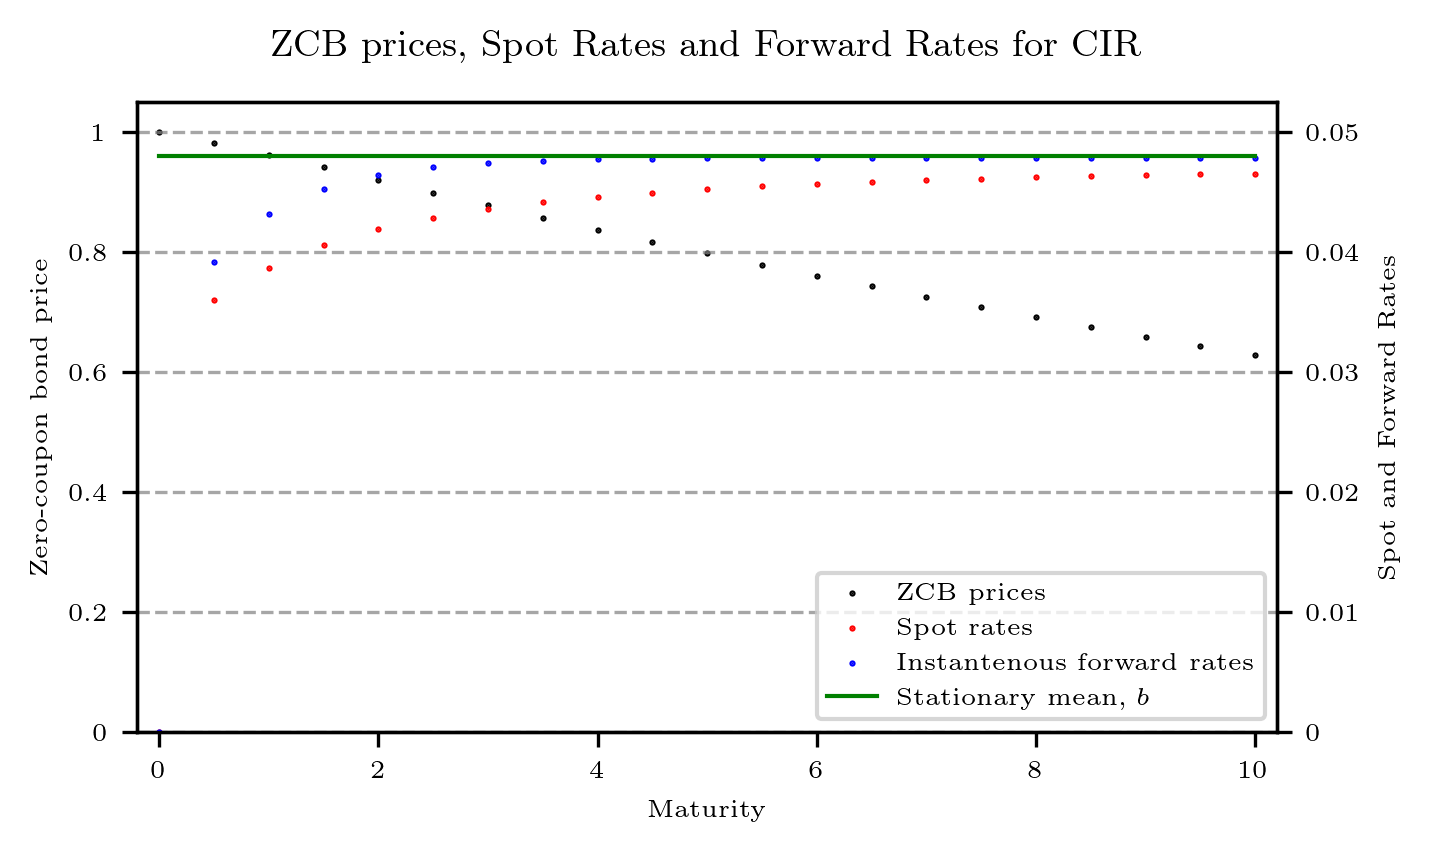

In [4]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))   #
fig.suptitle(f"ZCB prices, Spot Rates and Forward Rates for CIR", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
#
xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1],fontsize = 6)
ax.set_ylim([0,1.05])
ax.set_ylabel(f"Zero-coupon bond price",fontsize = 6)
ax.grid(axis='y', linestyle='--', color='grey', alpha=0.7)

p1 = ax.scatter(tau, ZCB_prices, s = 1, color = 'black', marker = ".",label="ZCB prices")

## add second y-axis for the rates
ax1 = ax.twinx()
ax1.set_ylabel(f"Spot and Forward Rates",fontsize = 6)
ax1.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06])
ax1.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.06],fontsize = 6)
ax1.set_ylim([0,0.0525])
p2 = ax1.scatter(tau, spot_rates, s = 1, color = 'red', marker = ".",label="Spot rates")
p3 = ax1.scatter(tau, forward_rates, s = 1, color = 'blue', marker = ".",label="Instantenous forward rates")
p4 = ax1.plot(tau, b*np.ones([N+1]), color = 'green', marker = "", linewidth = 1, linestyle = "solid",label = "Stationary mean, $b$")


plots = [p1,p2,p3,p4[0]]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
plt.show()

* ZCB prices decay
* Term structure of spot rates is upward sloping 
* Current rate of spot rate is below the stationary mean.
* Term structure of Forward rates is typically a bit further ahead.

## Fitting the Model

**Fitting, not knowing $\sigma$**

Using the parameters given above we fit all the parameters in a Vasicek model to the spot rates. 
The purpose is to check if we are able to recover the parameters of the Vasicek model.

In [5]:
param_0 = 0.03, 0.4, 0.05, 0.03  # initial parameters (random guess)

# note, you might need to change tolerance if too many function evaluations
result = minimize(fid.fit_cir_obj, param_0, args=(spot_rates, tau), method='Nelder-Mead', options={'xatol': 1e-12, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 242
         Function evaluations: 466


In [6]:
print(f'The fitted values are: r_0 = {result.x[0]:.4f}, a = {result.x[1]:.4f}, b = {result.x[2]:.4f}, and sigma = {result.x[3]:.4f}')
print(f'SSE of the fit {result.fun:.6f}') # not surprisingly, it depends on xatol!

The fitted values are: r_0 = 0.0320, a = 1.2093, b = 0.0478, and sigma = -0.0306
SSE of the fit 0.000000


Fitting the CIR model to spot rates with the objective of recovering all four parameters, we discover that $\sigma$ is difficult to recover implying that $\sigma$ is not well-specified in this model. Despite our inability to recover $\sigma$, we are nonetheless able to recover the remaining parameters $r_0, a$ and $b$ quite well.

**Fitting, knowing $\sigma$**

We do not recover sigma well. So suppose instead we know that sigma is some value. So we remove sigma from param and just put it as an input like "spot_rates" and "tau".

In [7]:
param_0 = 0.03, 0.4, 0.05 # no sigma!
result = minimize(fid.fit_cir_no_sigma_obj,param_0, method= "nelder-mead", args=(sigma, spot_rates,tau), options={'xatol': 1e-12, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 209
         Function evaluations: 387


In [8]:
print(f'The fitted values are: r_0 = {result.x[0]:.4f}, a = {result.x[1]:.4f}, b = {result.x[2]:.4f}')
print(f'SSE of the fit {result.fun:.6f}') # not surprisingly, it depends on xatol!

The fitted values are: r_0 = 0.0320, a = 1.2000, b = 0.0480
SSE of the fit 0.000000


If we fit the CIR model to spot rates assuming that $\sigma=0.02$ is known the algorithm will converge very fast and the remaining parameters be returned with high accuracy illustrating once again that $r_0, a$ and $b$ are very will identified in the model

## Simulating

Now we will simulate short rates in the CIR model using the usual first order Euler scheme on a grid of mesh $\delta$ that runs from initial time $t_0=0$ to terminal time $T=10$. Denote by $M$, the number of steps in your simulation. The time points in your simulation will be numbered $m=0,1,2, \ldots, M-1, M$ and the time points will be $\left[t_0, t_1, \ldots, t_{M-1}, t_M\right]=[0, \delta, 2 \delta, \ldots, T-\delta, T]$ and $\delta=\frac{T}{M}$. The scheme you will need to implement is a simple Euler first-order scheme of the form
$$
r_m=r_{m-1}+a\left(b-r_{m-1}\right) \delta+\sigma \sqrt{r_{m-1}} \sqrt{\delta} Z_m, \quad m=1,2, \ldots, M
$$
where $Z_m \sim N(0,1), m=1, \ldots, M$ and all the standard normal random variables are independent.

### Simulating One Trajectory

In [9]:
r0, a, b, sigma = 0.032, 1.2, 0.048, 0.1
size_ci = 0.95 # confidence interval
T, N = 10, 50_000 # maturity, time steps 
param = (a,b,sigma)
delta = T/N # step size
r = fid.short_rate_simul(r0,param,N,T,method = "cir")
tau = np.array([i*delta for i in range(0,N+1)])

# confidence bounds
N_ci = 100 # need to be a large number
t_ci = [i*T/N_ci for i in range(0,N_ci+1)]
lb,ub = fid.ci_cir(r0,a,b,sigma,t_ci,size_ci,method = "two_sided") # lower & upper bound
alpha, beta = (2*a*b)/(sigma**2), sigma**2/(2*a)
lb_sd, ub_sd = gamma.ppf(0.025, alpha, loc=0, scale=beta)*np.ones([N_ci+1]), gamma.ppf(0.975, alpha, loc=0, scale=beta)*np.ones([N_ci+1])

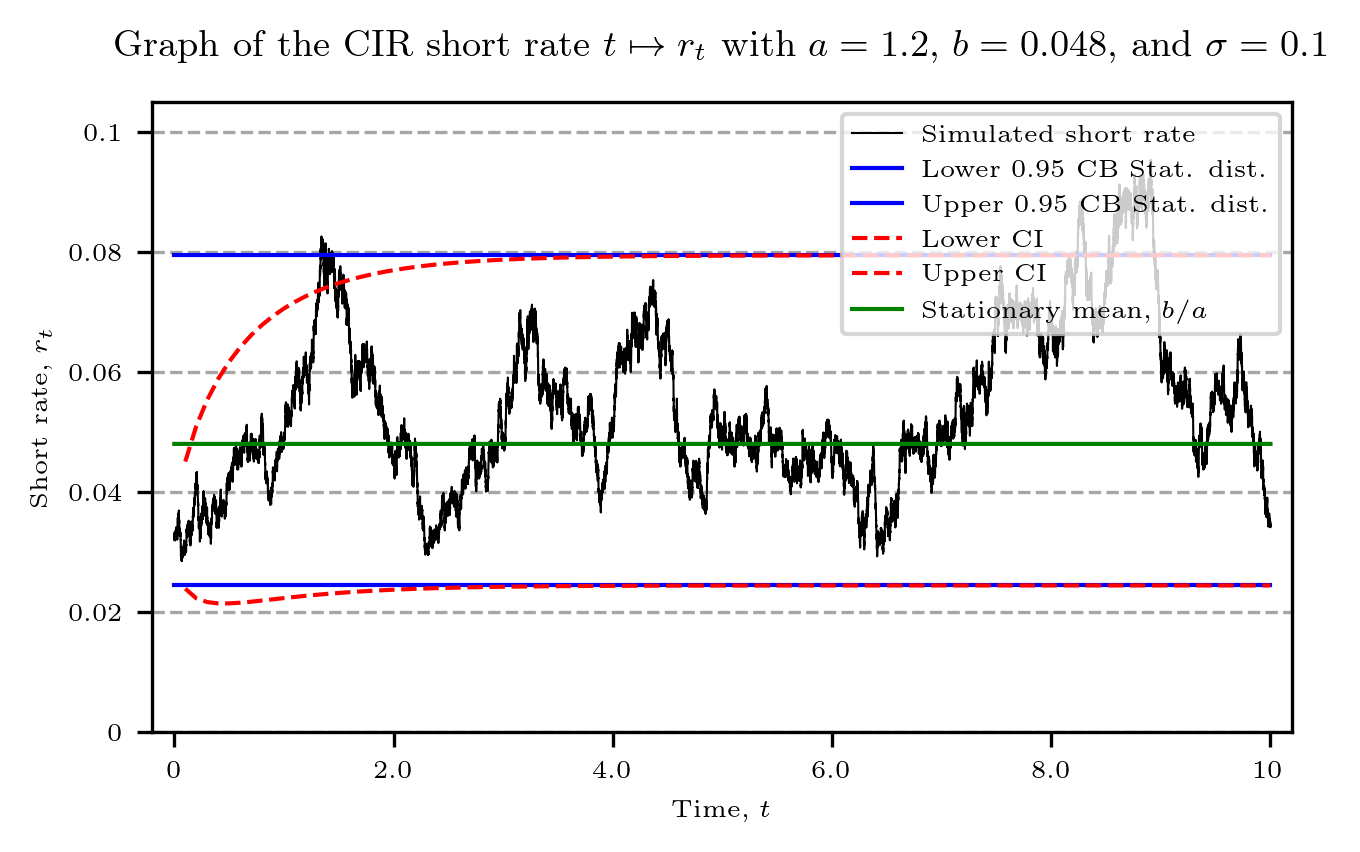

In [10]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))   #
fig.suptitle(f"Graph of the CIR short rate $t \mapsto r_t$ with $a={a}$, $b={b}$, and $\sigma={sigma}$", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
ax.grid(axis='y', linestyle='--', color='grey', alpha=0.7)


xticks = [0,(1/5)*T,(2/5)*T,(3/5)*T,(4/5)*T,T]
xticklabels = [round(i,3) for i in xticks]
yticks = [0,0.02,0.04,0.06,0.08,0.1]

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,fontsize = 6)
ax.set_xlim([xticks[0]-0.2,xticks[-1]+0.2])
plt.xlabel(f"Time, $t$",fontsize = 6)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks,fontsize = 6)
ax.set_ylim([yticks[0],yticks[-1]*1.05])
ax.set_ylabel(f"Short rate, $r_t$",fontsize = 6)

# simulated short rate
ax.plot(tau, r, color = 'black', marker = "",linewidth = 0.5, label = "Simulated short rate")

# stationary CI
ax.plot(t_ci,lb_sd,color = 'blue',marker = "", linewidth = 1, label = "Lower 0.95 CB Stat. dist.")
ax.plot(t_ci,ub_sd,color = 'blue',marker = "", linewidth = 1, label = "Upper 0.95 CB Stat. dist.")

# Simulated CI
ax.plot(t_ci, lb, color = 'red', marker = "", linewidth = 1, linestyle = "dashed", label = "Lower CI")
ax.plot(t_ci, ub, color = 'red', marker = "", linewidth = 1, linestyle = "dashed", label = "Upper CI")

# stationary mean
ax.plot(tau, b*np.ones([N+1]), color = 'green', marker = "", linewidth = 1, linestyle = "solid",label = "Stationary mean, $b/a$")


ax.legend(loc = "upper right",fontsize = 6)
plt.show()

* Confidencen bounds should narrow as it comes closer to the bounds of the statioanry distribution.

The value $r_3$ in the simulation is the short three years after the initial point, and since the confidence interval of $r_3$ is close to that of the stationary distribution, we can conclude that after 3 years the short rate has most likely almost settled to its stationary distribution. Convergence to the stationary distribution will be faster if either $a$ is large or $\sigma$ is small.

## Swap Rates

We know the first half-year, so we don't have to take into account that some time of the initial libor rate has already past.
$$
R_{\text {swap }}(t=0)=\frac{P(0,0)-p(0, N)}{S_{\text {swap }}}
$$

Where the denominator is the accrual factor which comes from the fixed leg: $\sum_{i=1}^N \alpha_i p\left(t, T_i\right)$ where $\alpha$ is tenor. The floating leg was simply since we could compute it as a telescoping sum.

Computing par swap rate (**remember to rerun begin of code**)

In [14]:
T_n = 0
T_N = 10 

R_swap = fid.zcb_to_par_swap_rate(T_n,T_N,'semiannual',tau,ZCB_prices)
print(f'R_swap is {R_swap}')

R_swap is 0.04680067874809556


**Alternatively**

In [17]:
# 10 Y swap price
#idx_n, idx_N = 0, 20 # first and last fixing where 20/2 = 10Y
#S_swap = 0 
#for idx in range(idx_n+1,idx_N+1): # already added 1 to M, hence no need for M+1 here, so M is included!
#    S_swap += 0.5*ZCB_prices[idx]

#R_swap = (ZCB_prices[idx_n]-ZCB_prices[idx_N])/S_swap

In [18]:
#print(f'R_swap is {R_swap}')

**New we have to do it for all maturities and not just for 10Y**

In [15]:
R_swap_vec = np.zeros([len(tau)]) # allocate memory
S_swap_vec = np.zeros([len(tau)]) # allocate memory


def R_swap_fct(T,fixed_freq,tau,ZCB_prices):
    """ Return swap rate for all maturities."""
    
    for i in range(1,len(tau)):
        S_swap_vec[i] = fid.zcb_to_accrual_factor(T[0],T[i],'semiannual',tau,ZCB_prices)
        R_swap_vec[i] = fid.zcb_to_par_swap_rate(T[0],T[i],'semiannual',tau,ZCB_prices)
    
    return R_swap_vec, S_swap_vec

R_swap_vec, S_swap_vec = R_swap_fct(tau,'semiannual',tau, ZCB_prices)

Alternatively, we can interpret duration as average time until you get your cash flow back, hence larger maturity the longer it takes to get investment back.Duration is a measure of when that happens. Hence why equal to maturity to ZCB. Hence duration of a bond is proportional to maturity. In our case, for maturity 10Y bond the S_Swap (accrual factor which is approx duration) is 8.11 years!

**Adding 6M Forward Rates**

In [16]:
forward_rats_6M = np.zeros([len(tau)])
forward_rats_6M = fid.zcb_to_forward_rates(tau,ZCB_prices,horizon = 1) # 6M for semiannual means 1 in horizon
forward_rats_6M

array([0.        , 0.03595898, 0.04135213, 0.04429405, 0.04590023,
       0.04677756, 0.0472569 , 0.04751883, 0.04766197, 0.0477402 ,
       0.04778295, 0.04780632, 0.04781909, 0.04782607, 0.04782988,
       0.04783197, 0.04783311, 0.04783373, 0.04783407, 0.04783426,
       0.04783436])

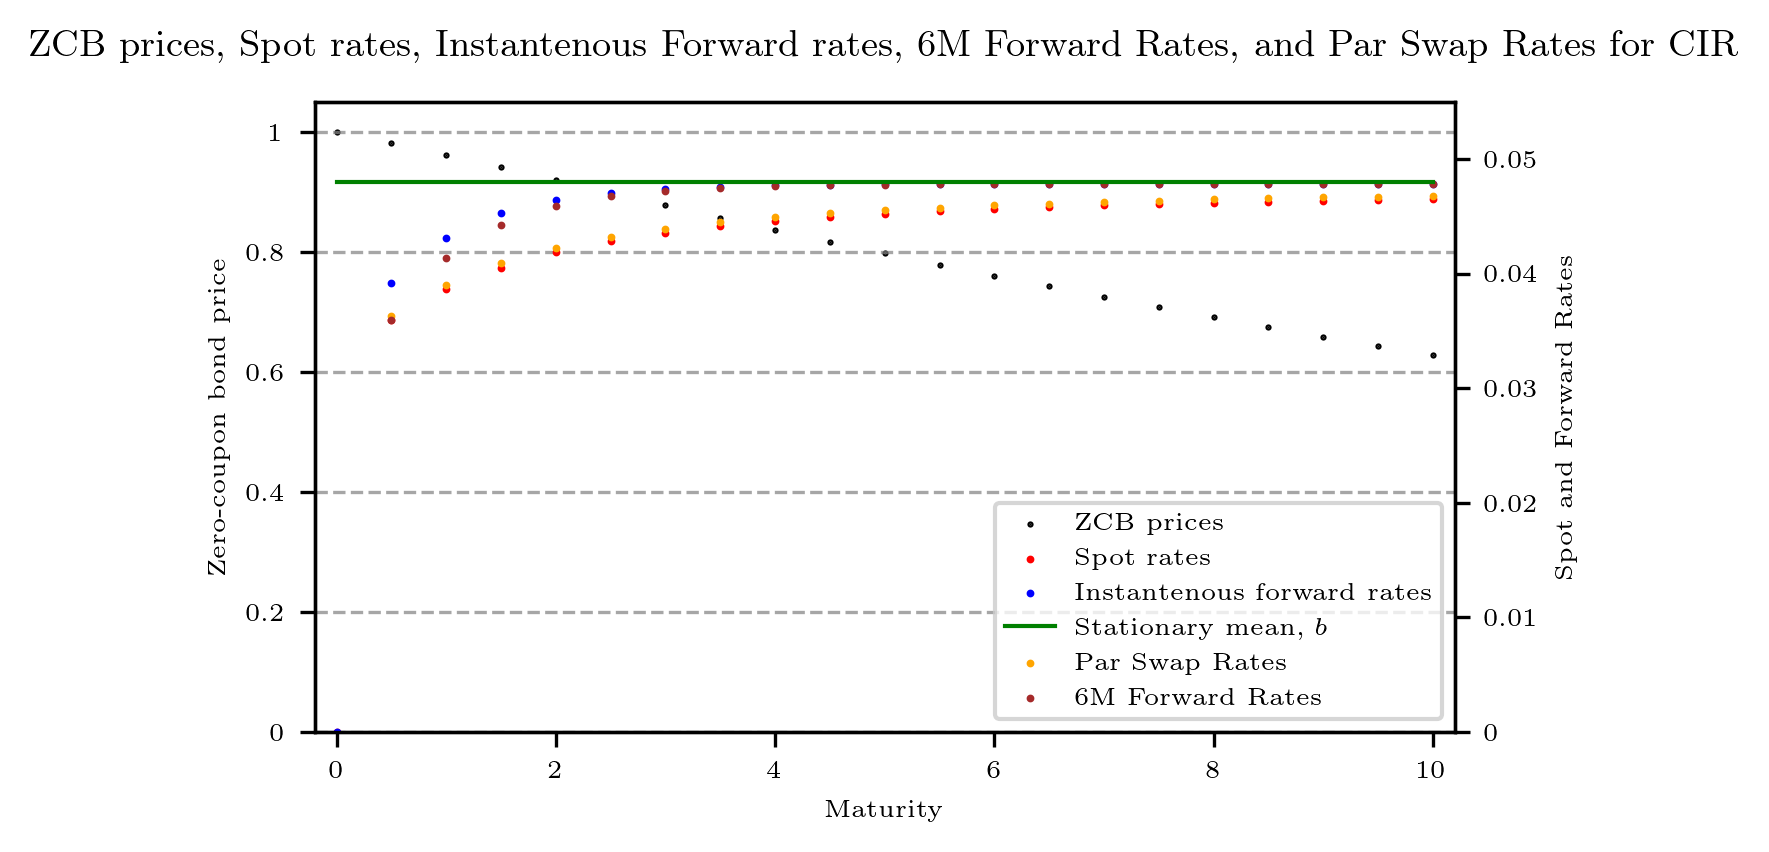

In [17]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))   #
fig.suptitle(f"ZCB prices, Spot rates, Instantenous Forward rates, 6M Forward Rates, and Par Swap Rates for CIR", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
#
xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1],fontsize = 6)
ax.set_ylim([0,1.05])
ax.set_ylabel(f"Zero-coupon bond price",fontsize = 6)
ax.grid(axis='y', linestyle='--', color='grey', alpha=0.7)

p1 = ax.scatter(tau, ZCB_prices, s = 1, color = 'black', marker = ".",label="ZCB prices")

## add second y-axis for the rates
ax1 = ax.twinx()
ax1.set_ylabel(f"Spot and Forward Rates",fontsize = 6)
ax1.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06])
ax1.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.06],fontsize = 6)
ax1.set_ylim([0,0.055])
p2 = ax1.scatter(tau, spot_rates, s = 3, color = 'red', marker = ".",label="Spot rates")
p3 = ax1.scatter(tau, forward_rates, s = 3, color = 'blue', marker = ".",label="Instantenous forward rates")
p4 = ax1.plot(tau, b*np.ones([N+1]), color = 'green', marker = "", linewidth = 1, linestyle = "solid",label = "Stationary mean, $b$")
p5 = ax1.scatter(tau[1:], R_swap_vec[1:], s = 3, color = 'orange', marker = ".",label="Par Swap Rates")
p6 = ax1.scatter(tau[1:], forward_rats_6M[1:], s = 3, color = 'brown', marker = ".",label="6M Forward Rates")

plots = [p1,p2,p3,p4[0],p5,p6]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
plt.show()

* We see that the par swap rates and ZCB spot rates are almost the same. 
    - The net cahs flow (fix - float) for payer swap is quite small, so the net payment until the end is relative small. 
    - Likewise, for ZCB the payment is at the very end. 
* Remember the accrual factor of a swap is change in value of swap if par-swap rate changes by 1 bp, essentially sensitive of bond price to changes in par-swap rate. Likewise, for a regular duration is the change in value of a bond for a unit change in YTM. So you can say that accrual factor plays same role as duration for ZCB. Notice, duration of ZCB is equal to maturity.
* Alternatively, we can interpret duration as average time until you get your cash flow back, hence larger maturity the longer it takes to get investment back.Duration is a measure of when that happens. Hence why equal to maturity to ZCB. Hence duration of a bond is proportional to maturity. In our case, for maturity 10 Y bond the S_Swap (accrual factor which is approx duration) is 8.11 years!
* Par swap rates are a weighted average of the $6 \mathrm{M}$ forward rates with more weight placed on forward rates over the near future.
* Par swap rates and zero coupon bond rates are relatively close because an interest rate swap is in nature quite close to a zero coupon bond. Now, a zero coupon bond band pays no coupons and has only one cashflow at the very end. The net coupons to an interest rate swap are however are also relatively small as they consist of the difference between the fixed par swap rate and the floating rate in this case 6M EURIBOR. Furthermore, since the fixed par swap rate is a weighted average of $6 \mathrm{M}$ forward rates, the average net coupon to an interest rate swap tends to be close to 0 .

## Interest Rate Cap

- Consider the pricing of an interest rate cap on future EURIBOR fixings that begins immediately and ends in T = 5 years. 
- The cap will have a strike of R=0.045.
- We will price this derivative using simulation.

An interest rate caplet caps, for a cost, the interest payment on a single floating rate payment. An interest rate cap caps a series of floating rate payments. An interest rate cap can thus be seen as the sum of a series of caplets and the price of a cap can therefore be computed as the sum of the prices of the caplets making up the interest rate cap. A caplet can be seen as a European call option with a specific future LIBOR rate fixing as the underlying asset or equivalently as a European put option on the ZCB price $p\left(T_{i-1}, T_i\right)$ realized at $T_{i-1}$, the time of a the LIBOR rate announcement, for 1 unit of currency delivered at the time $T_i$ of payment of the LIBOR rate.

**i) Deduce an expression for the discounted payoff of a caplet at time $t=0$ on the underlying reference rate $L\left(T_{i-1}, T_i\right)$.**

Assume that we have simulated the short rate from time $t=0$ to time $T_i$ using $M$ steps and denote the realized values of the short rate by $r_0, r_1, \ldots, r_{M-1}$. The payoff of at caplet with strike $R$ and underlying asset $L\left(T_{i-1}, T_i\right)$ discounted back to time $t=0$, denoted $\tilde{\chi}_i$, is then
$$
\tilde{\chi}_i=\exp \left\{-\frac{T}{M} \sum_{m=0}^{M-1} r_m\right\} \cdot\left[1+\left(T_i-T_{i-1}\right) R\right]\left(\frac{1}{1+\left(T_i-T_{i-1}\right) R}-p\left(T_{i-1}, T_i\right)\right)_{+}
$$

**ii) Simulate at least $N=1,000$ trajectories for the short rate up to time $T=5$ and in each simulation, at least $M=1,000$ steps should be taken. 
For each simulated path, compute the discounted payoffs to all caplets with a maturity less than 5 years. Once you have simulated $N$ trajectories, you can compute the price of the caplets by averaging the discounted payoffs.**

We compute price of interest rate cap in the CIR model:

In [63]:
T_cap_begin, T_cap_end = 0.5, 5
strike = 0.045 # strike rate, K
alpha = 0.5
idx_cap_begin, idx_cap_end = int(T_cap_begin/alpha), int(T_cap_end/alpha) # 1,10
price_caplet = np.zeros([idx_cap_end+1])
M_simul_cap, N_simul = 1_000, 10_000
chi = np.zeros([idx_cap_end-1,N_simul])

Simulate:

In [64]:
r_simul_cap = np.zeros([M_simul_cap])
for i in range(0,N_simul):
    r_simul_cap = fid.short_rate_simul(r0,(a,b,sigma),M_simul_cap,T_cap_end,method= "cir")
    for idx in range(idx_cap_begin,idx_cap_end):
        idx_r0 = idx*int((alpha*M_simul_cap)/T_cap_end)
        p_cap = fid.zcb_price_cir(r_simul_cap[idx_r0],a,b,sigma,alpha)
        chi[idx-1,i] = np.exp(-sum(r_simul_cap[0:idx_r0])/idx_r0)*(1+alpha*strike)*max(1/(1+alpha*strike)-p_cap,0)

In [69]:
for idx in range(idx_cap_begin+1,idx_cap_end+1):
    price_caplet[idx] = sum(chi[idx-2,:])/N_simul
print(f'Caplet prices is {price_caplet*10_000} in bps and the price of the cap is {sum(price_caplet)} is bps')


Caplet prices is [ 0.          0.          8.87593796 17.03293289 22.5944695  25.64742312
 27.11331666 27.99282175 28.1313718  28.44964207 28.9219353 ] in bps and the price of the cap is 0.021475985104928565 is bps


The lower the strike the higher the price of the interest rate cap. Since an interest cap is a sum of caplets each of which are simply European options, the price of the cap is increasing in σ.

## Payer Swaption

Also compute the price of a $2 \mathrm{Y} 3 \mathrm{Y}$ payer swaption with a strike of $K=0.045$ by using a similar approach of computing discounted payoffs for each trajectory and averaging over all simulations.

In this case, the discounted payoff becomes
$$
\tilde{\chi}=\exp \left\{-\frac{T}{M} \sum_{m=0}^{M-1} r_m\right\} \cdot S_{s w a p}\left(R_{s w a p}-K\right)_{+}
$$

Here, $M=2000$ is the number of steps in the simulation up to time $T=2, S_{s w a p}$ is the accrual factor of the underlying $3 \mathrm{Y}$ swap in $T=2$ years when the swaption expires and $R_{s w a p}$ is the par swap rate of the then $3 \mathrm{Y}$ swap. As mentioned above, the simulation was repeated $N=20000$ times and we get that the price of the swaption becomes $85.70 \mathrm{bps}$.

In [147]:
# compute price for 2Y3Y Swaption
idx_n_swaption, idx_N_swaption = 4, 10 # T_n = 2, T_N = 10
M_simul_swaption, N_simul, T_simul_swaption = 2_000, 2_000, tau[idx_n_swaption] # steps, trajectories and T_n 

In [148]:
chi, price_swaption_simul = np.zeros([N_simul]), np.zeros([N_simul])
T_swaption = np.array([tau[i]-tau[idx_n_swaption] for i in range(idx_n_swaption,idx_N_swaption+1)])

In [149]:
T_swaption

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. ])

In [150]:
R_swaption = 0.045
alpha = 0.5

In [158]:
def R_swap_fct(idx_n,idx_N,alpha,p):
    """ Return swap rate for all maturities. """
    S_swap = 0 
    for idx in range(idx_n+1,idx_N+1): # already added 1 to M, hence no need for M+1 here, so M is included!
        S_swap += alpha*p[idx]

    R_swap = (p[idx_n]-p[idx_N])/S_swap
    
    return R_swap, S_swap

In [159]:
for i in range(0, N_simul):
    r_simul_swaption = fid.short_rate_simul(r0,(a,b,sigma),M_simul_swaption,T_simul_swaption,method='cir')
    p_swaption = fid.zcb_price_cir(r_simul_swaption[-1],a,b,sigma,T_swaption)
    R_swap, S_swap = R_swap_fct(0,idx_N_swaption-idx_n_swaption,alpha,p_swaption)
    chi[i] = max(R_swap-R_swaption,0)*S_swap
    price_swaption_simul[i] = np.exp(-(1/M_simul_swaption)*sum(r_simul_swaption))*chi[i]
    
price_swaption = sum(price_swaption_simul)/N_simul
print(f'price swaption: {price_swaption*10_000} in bps')

price swaption: 91.39421481608075 in bps
